In [1]:
import scipy.io as sci
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
from datetime import datetime

In [2]:
# 文件载入
openPriceF = sci.loadmat(r'C:\Users\mikel\Desktop\Guosheng\Daily\AllStock_DailyOpen_dividend.mat')
closePriceF = sci.loadmat(r'C:\Users\mikel\Desktop\Guosheng\Daily\AllStock_DailyClose_dividend.mat')
listedDaysF = sci.loadmat(r'C:\Users\mikel\Desktop\Guosheng\Daily\AllStock_DailyListedDate.mat')
stF = sci.loadmat(r'C:\Users\mikel\Desktop\Guosheng\Daily\AllStock_DailyST.mat')
dailyStatusF = sci.loadmat(r'C:\Users\mikel\Desktop\Guosheng\Daily\AllStock_DailyStatus.mat')
tradingDateF = sci.loadmat(r'C:\Users\mikel\Desktop\Guosheng\Daily\TradingDate_Daily.mat')
stockCodeF = sci.loadmat(r'C:\Users\mikel\Desktop\Guosheng\Daily\AllStockCode.mat')
zz500 = pd.read_excel(r'C:\Users\mikel\Desktop\Guosheng\指数成分股 300&500.xlsx',sheet_name='中证500',header = 0)

In [3]:
# 导入文件中的数据到np array
openPrice = openPriceF['AllStock_DailyOpen_dividend']
closePrice = closePriceF['AllStock_DailyClose_dividend']
listedDays = listedDaysF['AllStock_DailyListedDate']
stStatus = stF['AllStock_DailyST']
dailyStatus = dailyStatusF['AllStock_DailyStatus_use']
tradingDate = tradingDateF['TradingDate_Daily']
stockCode =  stockCodeF['AllStockCode']

In [4]:
# 样本大小
stocks = openPrice.shape[1]   # 4952 stocks
days = openPrice.shape[0]
startDay = 2240
endDay = 3407
validDays = endDay - startDay

In [7]:
#尋找列數
def find_col(x):
    yearDigit = tradingDate[x]//10000
    monthDigit = tradingDate[x]//100%100
    col_index = (yearDigit - 2007)*12 + monthDigit - 1
    return col_index

In [8]:
#是否为中证500成分股
isZz500 = np.zeros((validDays,stocks))
for j in range(validDays):
    for k in range(stocks):
        i = find_col(validDays + startDay)
        if stockCode[0][k][0] in zz500.iloc[:,i].values:
                isZz500[j][k] = 1

In [29]:
# 挑出要选的样本,用表isValid作标记
isValid = np.zeros((validDays,stocks))
for i in range(startDay,endDay):
    for j in range(stocks):
        if listedDays[i][j] > 60 and stStatus[i][j] == 0 and dailyStatus[i-1][j] == 1 and dailyStatus[i][j] == 1 and openPrice[i][j] < closePrice[i-1][j]:
            isValid[i-startDay][j] = 1
        else: 
            isValid[i - startDay][j] = 0

In [35]:
# 统计低开、高开、低开高走、高开高走比例
diKai = 0
gaoKai = 0
diKaiGaoZou = 0
gaoKaiGaoZou = 0
countx = 0
for i in range(startDay,endDay):
    for j in range(stocks):
        if isZz500[i - startDay][j] == 1 and listedDays[i][j] > 60 and stStatus[i][j] == 0 and dailyStatus[i-1][j] == 1 and dailyStatus[i][j] == 1:
            countx = countx + 1
            if openPrice[i][j] < closePrice[i-1][j]:
                diKai = diKai + 1
                if openPrice[i][j] < closePrice[i][j]:
                    diKaiGaoZou = diKaiGaoZou + 1
            if openPrice[i][j] > closePrice[i-1][j]:
                gaoKai = gaoKai + 1
                if openPrice[i][j] < closePrice[i][j]:
                    gaoKaiGaoZou = gaoKaiGaoZou + 1
                    
print(countx)
print(diKai/(diKai + gaoKai))
print(diKaiGaoZou/diKai)
print(gaoKaiGaoZou/gaoKai)

506843
0.5596824000534246
0.5287023855566436
0.5032346465423014


In [31]:
# 辅助函数，用于计算值X在数组V中的排序位置
def percentile_rank(x,v):
    return (v <= x).sum() / len(v)

In [32]:
#将样本根据低开幅度分为10组,存于表diKaiFuDu中
diKaiFuDu = np.zeros((validDays,stocks))
print(diKaiFuDu.shape)
for i in range(startDay,endDay):
    sampleList = []
    for j in range(stocks):
        if isValid[i-startDay][j] == 1 and isZz500[i - startDay][j] == 1:
            sampleList.append(1 - openPrice[i][j]/closePrice[i-1][j])
    sampleArray = np.array(sampleList)
    for j in range(stocks):
        if isValid[i-startDay][j] == 1 and isZz500[i - startDay][j] == 1:
            fuDu = 1 - openPrice[i][j]/closePrice[i-1][j]
            percentile = percentile_rank(fuDu,sampleArray)
            if percentile != 1:
                diKaiFuDu[i - startDay][j] = percentile * 100 // 10 + 1
            else:
                diKaiFuDu[i - startDay][j] = 10

(1167, 4952)


In [33]:
# 计算所选样本当日回报率
dailyReturnArray = np.zeros(10)
returnArray = np.zeros((10,validDays))
counter = np.zeros((10,validDays))
lowPriceF = sci.loadmat(r'C:\Users\mikel\Desktop\Guosheng\Daily\AllStock_DailyLow_dividend.mat')
lowPrice = lowPriceF['AllStock_DailyLow_dividend']
for i in range(startDay,endDay): 
    for j in range(stocks):
        if isValid[i - startDay][j] == 1 and isZz500[i - startDay][j] == 1:
            if lowPrice[i][j]/closePrice[i-1][j] - 1 < -0.098:
                returnRate = lowPrice[i][j]/openPrice[i][j] - 1
            else:
                returnRate = closePrice[i][j]/openPrice[i][j] - 1
            returnArray[int(diKaiFuDu[i - startDay][j]) - 1][i - startDay] = returnArray[int(diKaiFuDu[i - startDay][j]) - 1][i- startDay] + returnRate
            counter[int(diKaiFuDu[i - startDay][j]) - 1][i - startDay] = counter[int(diKaiFuDu[i - startDay][j]) - 1][i - startDay] + 1

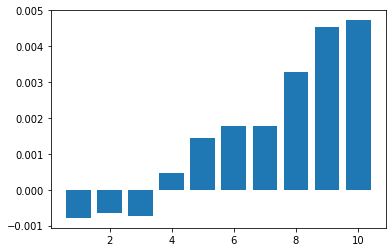

In [34]:
#画图
dailyAverageReturn = np.zeros([10,validDays])
for i in range(10):
    for j in range (validDays):
        if counter[i][j] != 0:
            dailyAverageReturn[i][j] = returnArray[i][j] / counter[i][j]
averageReturn = np.average(dailyAverageReturn, axis=1) 
plt.bar(range(1,len(averageReturn)+1), averageReturn)
plt.show()